In [2]:
import pandas as pd
df = pd.read_csv("movies_topic_modeling.csv")

#Dropping non-numeric variables
df = df.drop([ "Title", "overview", "tagline", "overview_processes"], axis=1)
df = pd.get_dummies(df, columns=['Rating'], drop_first=False)
df["Movie_Hits"] = df["Movie_Hits"].fillna(0)


Best params for Netflix: {'logreg__C': 0.01, 'logreg__l1_ratio': 0.5}
Best CV AUC for Netflix: 0.6911

=== Coefficients for Netflix ===
                    Feature  Coefficient
0                      Year     0.341041
5                   runtime     0.116537
16                    Crime     0.048820
25                  Romance     0.045262
33         overview_neutral     0.000000
26          Science Fiction     0.000000
27                 TV Movie     0.000000
28                 Thriller     0.000000
29                      War     0.000000
30                  Western     0.000000
31        overview_positive     0.000000
32        overview_negative     0.000000
34        overview_compound     0.000000
23                    Music     0.000000
35    Personal Growth Drama     0.000000
36           Group Conflict     0.000000
37  Mission-Driven Thriller     0.000000
38       Small-Town Heroism     0.000000
39                 Rating_G     0.000000
40                Rating_PG     0.000000
41

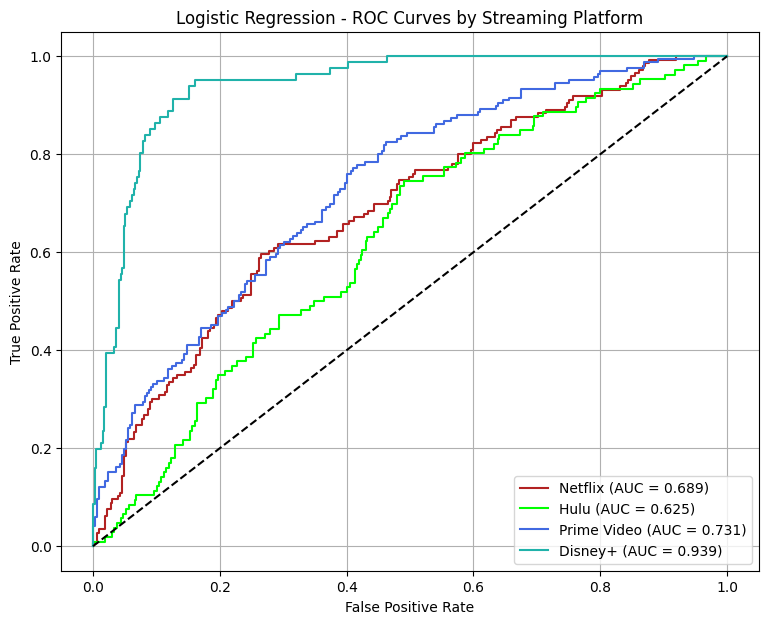


===== PERFORMANCE METRICS =====
      Platform  Accuracy  F1 Score  Sensitivity  Specificity  Test AUC  \
0      Netflix  0.692144  0.545455     0.595890     0.735385  0.689484   
1         Hulu  0.562633  0.434066     0.745283     0.509589  0.625433   
2  Prime Video  0.639066  0.617117     0.825301     0.537705  0.730713   
3      Disney+  0.857749  0.696833     0.950617     0.838462  0.939126   

   Best Threshold  
0        0.539112  
1        0.437808  
2        0.466823  
3        0.235797  


In [3]:
# =============================
# IMPORTS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, f1_score, accuracy_score
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# =============================
# DATA PREP
# =============================
#defining targets
targets = ["Netflix", "Hulu", "Prime Video", "Disney+"]
X = df.drop(columns=targets)

# Scale numeric only
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

scaler = StandardScaler() #scaling data 
X_scaled_num = scaler.fit_transform(X[num_cols]) 

# Reassemble final X
X_processed = pd.DataFrame(X_scaled_num, columns=num_cols)
X_processed[cat_cols] = X[cat_cols].reset_index(drop=True)

# Storage
roc_info = {}
best_thresholds = {}
best_params = {}
performance_table = []
valid_targets = []
coef_table = {}   
#set up cross validation
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================
# MODEL TRAINING PER TARGET
# =============================
#run model on each of the streaming platforms
for t in targets:
    y = df[t]

    # Skip targets with too few positives
    if y.sum() < 5:
        print(f"Skipping {t}: too few positive samples ({y.sum()})")
        continue

    valid_targets.append(t)

    # Train-test split stratified per target
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    # Pipeline: SMOTE + Elastic Net LR
    pipe = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("logreg", LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            max_iter=5000,
            class_weight="balanced"
        ))
    ])

    # Hyperparameter grid
    param_grid = {
        "logreg__C": [0.01, 0.1, 1, 10],
        "logreg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    # GridSearchCV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv_outer,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_params[t] = grid.best_params_
    print(f"\nBest params for {t}: {grid.best_params_}")
    print(f"Best CV AUC for {t}: {grid.best_score_:.4f}")

    # ---- NEW: Extract model coefficients ----
    # Get the fitted pipeline and the LR model inside it
    best_model = grid.best_estimator_
    lr_model = best_model.named_steps["logreg"]

    # Coefficients correspond to columns of X_processed
    coef_df = pd.DataFrame({
        "Feature": X_processed.columns,
        "Coefficient": lr_model.coef_[0]
    }).sort_values(by="Coefficient", ascending=False)

    coef_table[t] = coef_df   # store for later
    print(f"\n=== Coefficients for {t} ===")
    print(coef_df)

    # Predict probabilities on test set
    prob_test = best_model.predict_proba(X_test)[:, 1]

    # ROC curve + best threshold (Youden J)
    fpr, tpr, thresholds = roc_curve(y_test, prob_test)
    best_thr = thresholds[np.argmax(tpr - fpr)]
    best_thresholds[t] = best_thr
    roc_auc = auc(fpr, tpr)
    roc_info[t] = (fpr, tpr, roc_auc)

    # Apply threshold
    y_pred = (prob_test >= best_thr).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    performance_table.append({
        "Platform": t,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Test AUC": roc_auc,
        "Best Threshold": best_thr
    })

# =============================
# PLOT ROC CURVES
# =============================


color_map = {
    "Netflix": "firebrick",
    "Hulu": "lime",
    "Prime Video": "royalblue",
    "Disney+": "lightseagreen"
}

plt.figure(figsize=(9, 7))
for t in valid_targets:
    fpr, tpr, auc_score = roc_info[t]
    plt.plot(
        fpr, tpr,
        label=f"{t} (AUC = {auc_score:.3f})",
        color=color_map.get(t, None)   # default None in case of missing
    )

plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curves by Streaming Platform")
plt.legend()
plt.grid(True)
plt.show()



# =============================
# PERFORMANCE TABLE
# =============================
perf_df = pd.DataFrame(performance_table)
print("\n===== PERFORMANCE METRICS =====")
print(perf_df)




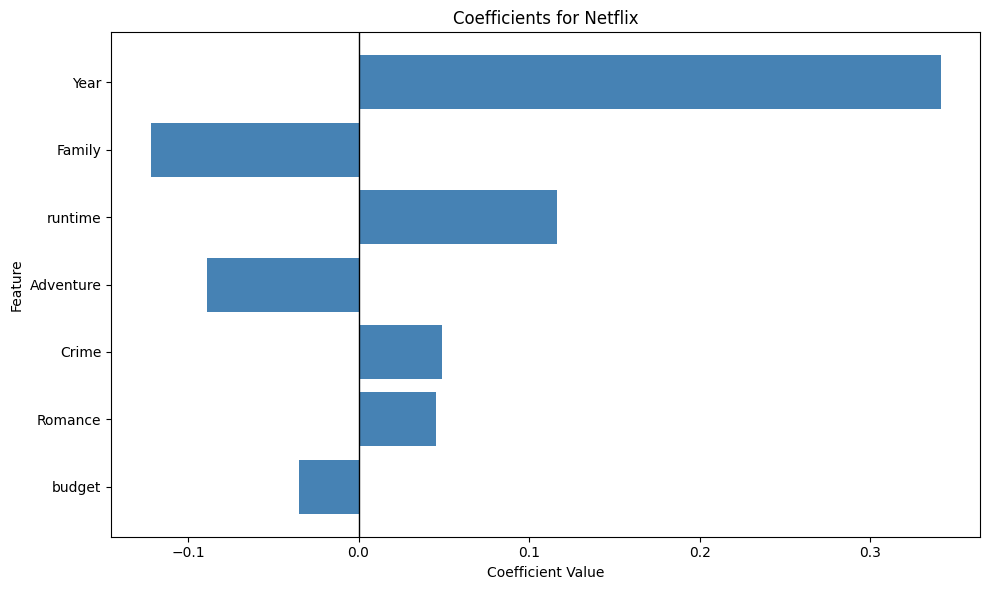

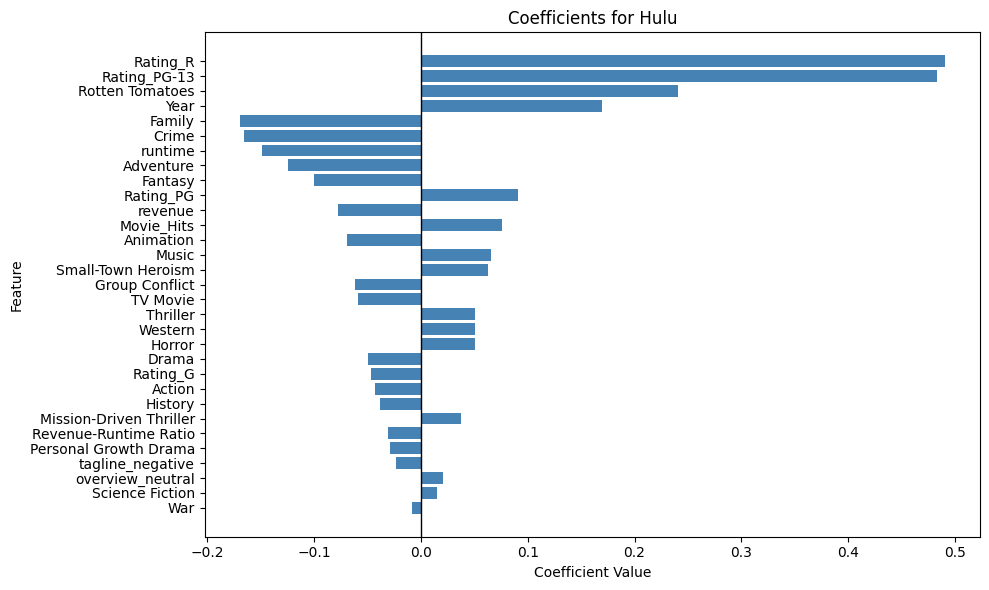

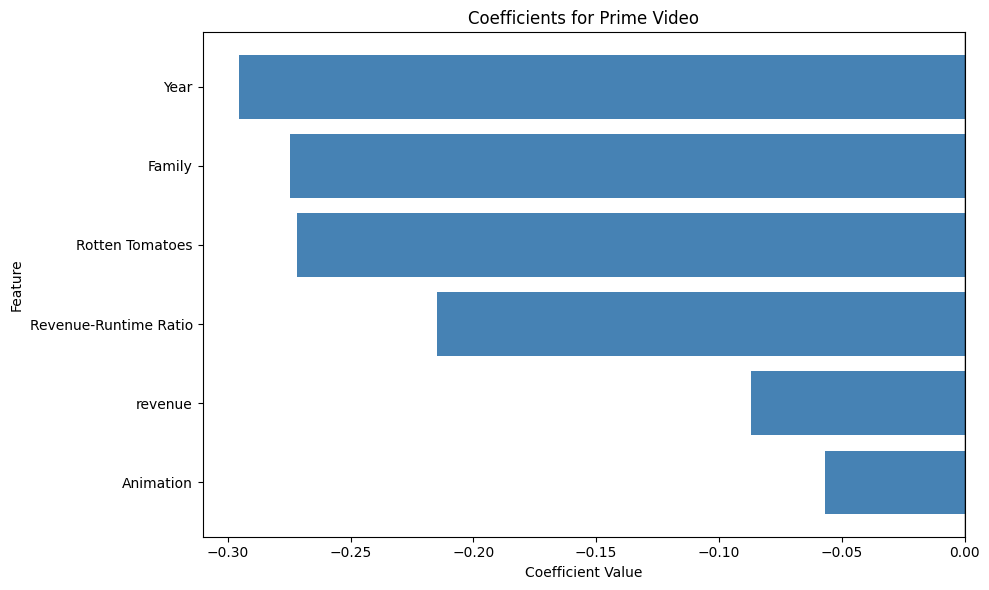

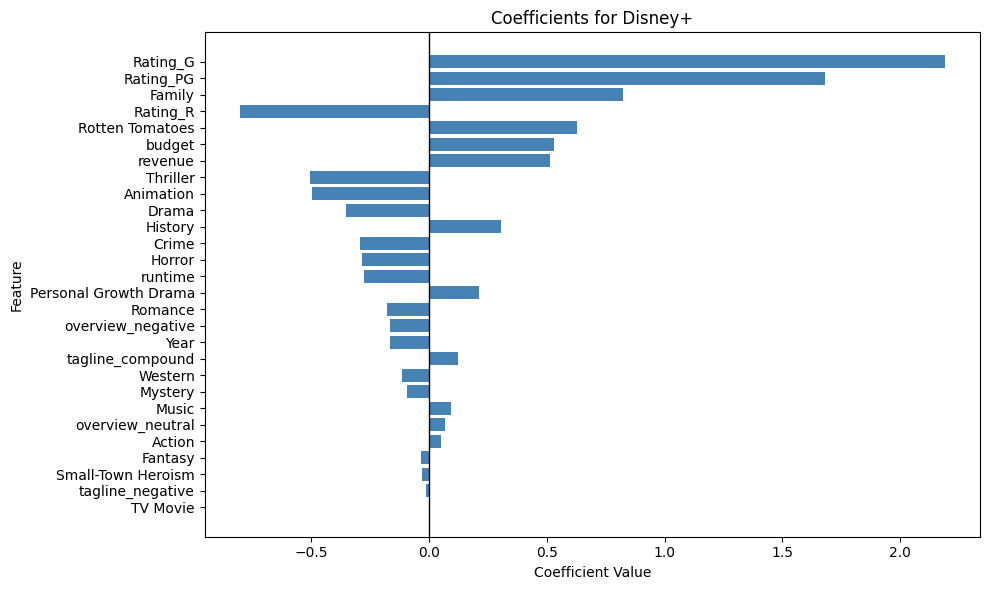

In [4]:
import matplotlib.pyplot as plt

# =============================
# PLOT NON-ZERO COEFFICIENTS FOR EACH MODEL
# =============================
for t in coef_table.keys():

    coef_df = coef_table[t]

    # Keep only non-zero coefficients
    nonzero = coef_df[coef_df["Coefficient"] != 0].copy()

    if nonzero.empty:
        print(f"No non-zero coefficients for {t}.")
        continue

    # Sort by absolute magnitude (optional but recommended)
    nonzero["AbsCoef"] = nonzero["Coefficient"].abs()
    nonzero = nonzero.sort_values("AbsCoef", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(nonzero["Feature"], nonzero["Coefficient"], color="steelblue")
    plt.axvline(0, color="black", linewidth=1)

    plt.title(f"Coefficients for {t}")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()   # Largest at top
    plt.tight_layout()
    plt.show()
